## Лабораторная работа 3.2. Композиции алгоритмов. Градиентный бустинг. Ранжирование c xgboost. catboost vs lightgbm

Постарайтесь оформить всю работу как один монолитный рассказ/отчет. Избегайте дублирования кода. Избегайте использования циклов, вместо этого ищите готовый алгоритм в пакетах. Подписывайте все графики, а также их оси, если график содержит несколько кривых, то обязательно пользуйтесь легендой. Также неукоснительно соблюдайте PEP8. За несоблюдение этих простейших правил итоговые баллы могут быть снижены безапелляционно.

### 1. (5 баллов) Bias-Variance decomposition.

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

Рассмотрим задачу регрессии со среднеквадратичной функцией потерь, а также некоторый алгорим $a$. Тогда качество алгоритма $a$ может быть записано следующим образом:

$$Q(a) = \mathbb{E}_{X^l} \mathbb{E}_{x,y}\left(a(x) - y\right)^2$$

где первое матожидание вычисляется по всевозможным обучающим выборкам $X^l$. К сожалению, на реальных данных эта формула неприменима из-за невозможности сгенерировать необходимые для оценки данные. Поэтому проведем приближенный численный эксперимент с эмпирическими оценками матожиданий.

Обозначим вектор истинных меток тестовой выборки за $y \in \mathbb{R}^{l}$. С помощью бутстраппинга можно просемплировать из обучающей выборки $N$ новых выборок того же размера, тем самым "имитируя" пространство всевозможных обучающих выборок, после чего обучить на каждой выбранный алгоритм. Векторы прогнозов для объектов из тестовой выборки для каждой модели обозначим за $\hat{y}_i \in \mathbb{R}^{l}, i \in \{1, .., N\}$. Тогда средний квадрат ошибки по всем моделям на тестовой выборке запишется как

$$error=\frac{1}{N}\sum_{i=1}^{N}MSE(y,\hat{y}_i)$$

Обозначим среднее предсказание за $$\overline{y} = \frac{1}{N}\sum_{i=1}^{N} \hat{y}_i$$

Тогда квадрат отклонения среднего предсказания и разброс прогнозов относительно среднего предсказания всех моделей на тестовой выборке от истинных меток запишутся следующим образом, соответственно:

$$bias^2 = MSE(y, \overline y)$$

$$variance = \frac{1}{N}\sum_{i=1}^N MSE(\hat{y}_i, \overline y)$$

Для начала рассмотрим в качестве алгоритма решающее дерево. Как известно, при увеличении высоты дерева алгоритм может быть сильно чувствителен к составу обучающей выборки. Чтобы подтвердить эти предположения, проведите следующие эксперименты.

Загрузите [набор данных](http://archive.ics.uci.edu/ml/datasets/BlogFeedback). Каждый объект — пост в блоге. Он описывается различными признаками: длина текста поста, наличие наиболее частотных слов, день недели, количество комментариев за последние 24 часа и т.п., а так же целевым признаком — количеством комментариев к посту. Полный список признаков и описание находятся на странице датасета. 

Разбейте данные из файла `blogData_train.csv` на обучающую и тестовую выборки в пропорциях 1 к 4 соответственно. Обратите внимание, что обучающая выборка меньше тестовой. Такая большая тестовая выборка позволит сделать измерение качества моделей достаточно достоверным. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
RANDOM_STATE = 648

In [3]:
data = pd.read_csv(Path('.', 'data', 'BlogFeedback', 'blogData_train.csv'),
                   header=None)

In [4]:
data.shape

(52397, 281)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0


In [6]:
data = np.array(data)

In [7]:
data.shape

(52397, 281)

In [8]:
X, y = data[:, :-1], data[:, -1]

In [9]:
X.shape, y.shape

((52397, 280), (52397,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

In [11]:
X_train.shape, X_test.shape

((10479, 280), (41918, 280))

**1. (3 балла)** Постройте графики зависимости $error$, $bias^2$ и $variance$ от глубины решающего дерева (от 1 до 15 включительно) для $N=100$. 

$$error=\frac{1}{N}\sum_{i=1}^{N}MSE(y,\hat{y}_i)$$

$$\overline{y} = \frac{1}{N}\sum_{i=1}^{N} \hat{y}_i$$
$$bias^2 = MSE(y, \overline y)$$

$$variance = \frac{1}{N}\sum_{i=1}^N MSE(\hat{y}_i, \overline y)$$

In [12]:
import multiprocessing as mp
import os
from functools import partial
from time import time
import pickle

mp.set_start_method('fork', force=True)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [13]:
n_threads = os.cpu_count() - 1

In [14]:
n_threads

3

In [15]:
rand_gen = np.random.default_rng(RANDOM_STATE)

In [16]:
def get_bs_ix(sample_size):
    return rand_gen.choice(np.arange(sample_size), size=sample_size)

In [17]:
N_bs = 100

In [18]:
def bs_model(fit_params, model):
    test_predicts = []
    times = []
    for _ in range(N_bs):
        start_t = time()
        bs_ix = get_bs_ix(X_train.shape[0])
        X_, y_ = X_train[bs_ix], y_train[bs_ix]

        y_pred = model(**fit_params).fit(X_, y_).predict(X_test)
        end_t = time()
        test_predicts.append(y_pred)
        times.append(end_t - start_t)
    return test_predicts, times

In [19]:
bs_dart = partial(bs_model, model=DecisionTreeRegressor)

In [20]:
cache_path = Path('.', 'caches')
cache_path.exists()

True

In [21]:
%%time
fname = cache_path.joinpath('bias_variance_data.pkl')
if fname.exists():
    all_y_list = pickle.load(fname.open('rb'))
else:
    with mp.Pool(processes=n_threads) as p:
        all_y_list = p.map(bs_dart, [{'max_depth': i,
                                      'random_state': RANDOM_STATE}
                                     for i in range(1, 16)])
    pickle.dump(all_y_list, fname.open('wb'))

CPU times: user 64.4 ms, sys: 599 ms, total: 663 ms
Wall time: 1.6 s


In [22]:
%%time
mean_time = np.array([sum(time for time in tries[1])/N_bs
                  for tries in all_y_list])
error = np.array([sum(mean_squared_error(y_test, y_pred)
                   for y_pred in tries[0])/N_bs
               for tries in all_y_list])

mean_predicts = np.array([np.mean(tries[0], axis=0) for tries in all_y_list])

bias_sq = np.array([mean_squared_error(y_test, mean_pred) 
                    for mean_pred in mean_predicts])

variance = np.array([sum(mean_squared_error(mean_pred, y_pred)
                   for y_pred in tries[0])/N_bs
               for mean_pred, tries in zip(mean_predicts, all_y_list)])

CPU times: user 2.01 s, sys: 96.9 ms, total: 2.1 s
Wall time: 3.58 s


Text(0, 0.5, 'seconds')

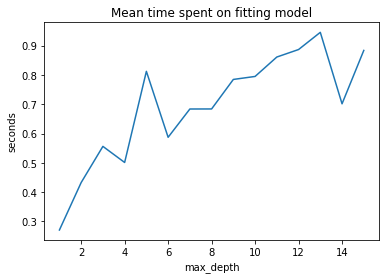

In [23]:
x = range(1, 16)
plt.plot(x, mean_time)
plt.title('Mean time spent on fitting model')
plt.xlabel('max_depth')
plt.ylabel('seconds')

Text(0, 0.5, 'MSE')

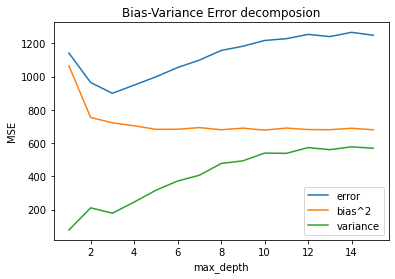

In [24]:
plt.plot(x, error, label='error')
plt.plot(x, bias_sq, label='bias^2')
plt.plot(x, variance, label='variance')

plt.legend()
plt.title('Bias-Variance Error decomposion')
plt.xlabel('max_depth')
plt.ylabel('MSE')

**2. (2 балла)** Являются ли какие-то из полученных графиков монотонными? А должны ли они быть монотонными, если бы гипотетически эксперименты были проведены на всевозможных выборках? Почему? Убедитесь численно, что верно bias-variance разложение ошибки: $$error = bias^2 + variance$$

__Ответ:__

Графики смещения и разброса являются монотонными, что и следовало ожидать. Смещение уменьшается, так как при увеличении сложности модели мы в среднем получаем меньшую большую точность модели. При этом разброс монотонно увеличивается, так как при увеличении сложности модели, модель сильнее переобучается и увеличивает ошибку модели на тестовой выборке.

Text(0.5, 1.0, 'Check equality Error = bias$^2$ + variance')

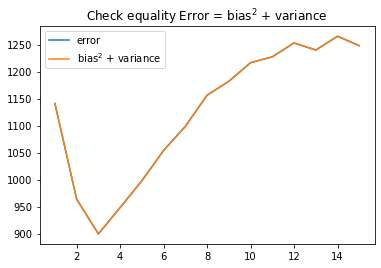

In [25]:
plt.plot(x, error, label='error')
plt.plot(x, variance + bias_sq, label='bias$^2$ + variance')

plt.legend()

plt.title('Check equality Error = bias$^2$ + variance')

In [26]:
mean_squared_error(error, variance + bias_sq)

1.5423471838228329e-25

In [27]:
np.allclose(error, variance + bias_sq)

True

Ошибка равна сумма разброса и смещения с очень высокой точностью

### 2. (7 баллов) Композиции алгоритмов. Градиентный бустинг


Несмотря на описанный выше недостаток решающих деревьев, объединение их в композиции позволяет существенно улучшить качество предсказания. Рассмотрим несколько способов построения композиций.

#### Bagging + RSM

![](https://sites.google.com/site/rajhansgondane2506/_/rsrc/1467898300734/publications/rrftrain.jpg?height=215&width=320)

Один из способов объединения алгоритмов в композиции — обучение каждого отдельного алгоритма на некоторой подвыборке из исходной выборки ([bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) и подмножестве исходных признаков ([RSM](https://en.wikipedia.org/wiki/Random_subspace_method)). В sklearn этот тип композиции реализован в классе [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (для случая регресии). Подобный подход также есть в реализации [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

#### Градиентный бустинг

В случае бустинга композиция алгоритмов строится последовательно. Каждый следующий базовый алгоритм акцентируется на тех объектах, на которых обученная ранее композиция допускала ошибку.

На данный момент одной из самых широко распространенных реализаций бустинга является библиотека [XGBoost](https://github.com/dmlc/xgboost). В ней большое внимание уделяется регуляризации и скорости, нежели в других реализациях бустинга (например,  [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из sklearn). Кроме того, XGBoost позволяет оптимизировать различные функции потерь, а также более гибок, засчет большого числа параметров.

XGBoost строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

минимизируя следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.

Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В случае бустинга над решающими деревьями регуляризатор имеет следующий вид:

$$ \Omega(b_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}w_j,$$

где 
 - $T$ — количество листьев в дереве;
 - $w_j$ — веса в листьях дерева;
 - $\lambda, \alpha, \gamma$ — гиперпараметры.

Данный регуляризатор подобран эвристически и хорошо показывает себя на практике. 

Раскладывая в ряд Тейлора выражение $\mathcal{L}\left(y_i, \hat{y}_i^{\left(t-1\right)} + b_t(x_i)\right)$ до второго порядка, получаем:

$$ Obj^{(t)} = \sum_{i=1}^N\left[\mathcal{L}(y_i, \hat{y}_i^{\left(t-1\right)}) + g_{i}b_{t}(x_i) + \frac{1}{2}h_{i}b_{t}^2(x_i)\right] + \Omega(b_t),$$

где $g_i = \partial_{\hat{y}_i^{(t-1)}} \mathcal{L}(y_i, \hat{y_i}^{(t-1)})$, $h_i = \partial_{\hat{y}_i^{(t-1)}}^2 \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $ — градиент и гессиан оптимизируемой функции потерь.

Приводя теперь подобные слагаемые и отбрасывая слагаемое $ \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $, не зависящее от $ b_t(x_i)$ (а следовательно, не влияющее на точку минимума функционала), получаем формулу:
$$ Obj^{(t)} \simeq \sum_{j=1}^{T}\left[\sum_{i \in I_j} g_i w_j + \frac{1}{2}\sum_{i \in I_j} (h_i + \lambda)w_j^2\right] + \gamma T$$
$$ = \sum_{j=1}^{T}\left[G_jw_j + \frac{1}{2}(H_j + \lambda)w_j^2\right] + \gamma T, $$

где 
 - $ I_j $ - множество объектов обучающей выборки, попавших в $j$-ый лист дерева;
 - $ G_j = \sum_{i \in I_j} g_i$;
 - $ H_j = \sum_{i \in I_j} h_i$.
 
Теперь, имея заданную структуру дерева, можно аналитически вычислить оптимальные значения для весов:
$$ w_j^* = -\frac{G_j}{H_j + \lambda}.$$

Значение функционала при этом будет равно:

$$ Obj = -\frac{1}{2}\sum_{j=1}^T \frac{G_j^2}{H_j + \lambda} + \gamma T .$$

Осталось только построить дерево оптимальной структуры. Это можно делать известными методами построения решающих деревьев, проводя разбиения таким образом, чтобы максимизировать gain, определенный как уменьшение $Obj$ в момент этого разбиения. Для уже построенного дерева по формулам $ w_j^* $ вычисляются оптимальные значения в листьях.

В XGBoost реализовано несколько различных функций потерь, что позволяет решать задачи классификации (бинарной и мультиклассовой), регрессии и ранжирования. Вот некоторые из них:

- `reg:linear` — линейная регрессия
- `reg:logistic` — логистическая регрессия
- `binary:logistic` — логистическая регрессия
- `multi:softmax` — softmax функция потерь для многоклассовой классификации
- `rank:pairwise` — минимизация pairwise-функции потерь для задачи ранжирования

**3. (4 балла)** Проведите аналогичный эксперимент с bias-variance разложением для градиентного бустинга для количество алгоритмов 1, 5, 10, 25 и 50, используя в качестве базовых алгоритмов решающие деревья. Пример использования библиотеки можно найти в туториале с семинара про XGBoost. Обратите внимание, что данная библиотека имеет два интерфейса (стандартный и аналог sklearn), названия параметров в которых могут отличаться.

In [28]:
import xgboost as xgb

In [29]:
model = xgb.sklearn.XGBRegressor

In [30]:
bs_gbm = partial(bs_model, model=model)

In [31]:
cache_path = Path('.', 'caches')
cache_path.exists()

True

In [32]:
%%time

n_list = [1, 5, 10, 25, 50]
graphs_dict = {i: {} for i in n_list}
for n_estim in n_list:
    start = time()
    fname = cache_path.joinpath(f'bias_variance_gbm_{n_estim}.pkl')
    if fname.exists():
        all_y_list = pickle.load(fname.open('rb'))
    else:
        with mp.Pool(processes=n_threads) as p:
            all_y_list = p.map(bs_gbm, [{'n_estimators': n_estim,
                                          'n_jobs': 1,
                                          'verbosity': 0,
                                          'random_state': RANDOM_STATE,
                                          'max_depth': i}
                                         for i in range(1, 16)])
        pickle.dump(all_y_list, fname.open('wb'))

    mean_time_gb = np.array([sum(time for time in tries[1])/N_bs
                      for tries in all_y_list])
    error_gb = np.array([sum(mean_squared_error(y_test, y_pred)
                       for y_pred in tries[0])/N_bs
                   for tries in all_y_list])

    mean_predicts_gb = np.array([np.mean(tries[0], axis=0) for tries in all_y_list])

    bias_sq_gb = np.array([mean_squared_error(y_test, mean_pred) 
                        for mean_pred in mean_predicts_gb])

    variance_gb = np.array([sum(mean_squared_error(mean_pred, y_pred)
                       for y_pred in tries[0])/N_bs
                   for mean_pred, tries in zip(mean_predicts_gb, all_y_list)])
    end = time()
    
    graphs_dict[n_estim]['time'] = mean_time_gb
    graphs_dict[n_estim]['error'] = error_gb
    graphs_dict[n_estim]['predicts'] = mean_predicts_gb
    graphs_dict[n_estim]['bias'] = bias_sq_gb
    graphs_dict[n_estim]['variance'] = variance_gb
    
    pickle.dump(graphs_dict, cache_path.joinpath('graphs_dict.pkl').open('wb'))
    print(f'{n_estim} done in {int(end - start) // 60} minutes.')

1 done in 0 minutes.
5 done in 0 minutes.
10 done in 0 minutes.
25 done in 0 minutes.
50 done in 0 minutes.
CPU times: user 9.31 s, sys: 2.05 s, total: 11.4 s
Wall time: 18.9 s


In [33]:
x = range(1, 16)

Text(0.5, 1.0, 'Mean fitting time of XGB model')

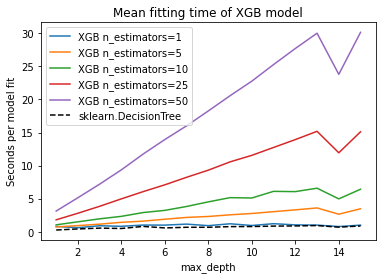

In [34]:
for i in n_list:
    plt.plot(x, graphs_dict[i]['time'], label=f'XGB n_estimators={i}')
    
plt.plot(x, mean_time, label='sklearn.DecisionTree', ls='--', c='black')
    
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Seconds per model fit')
plt.title('Mean fitting time of XGB model')

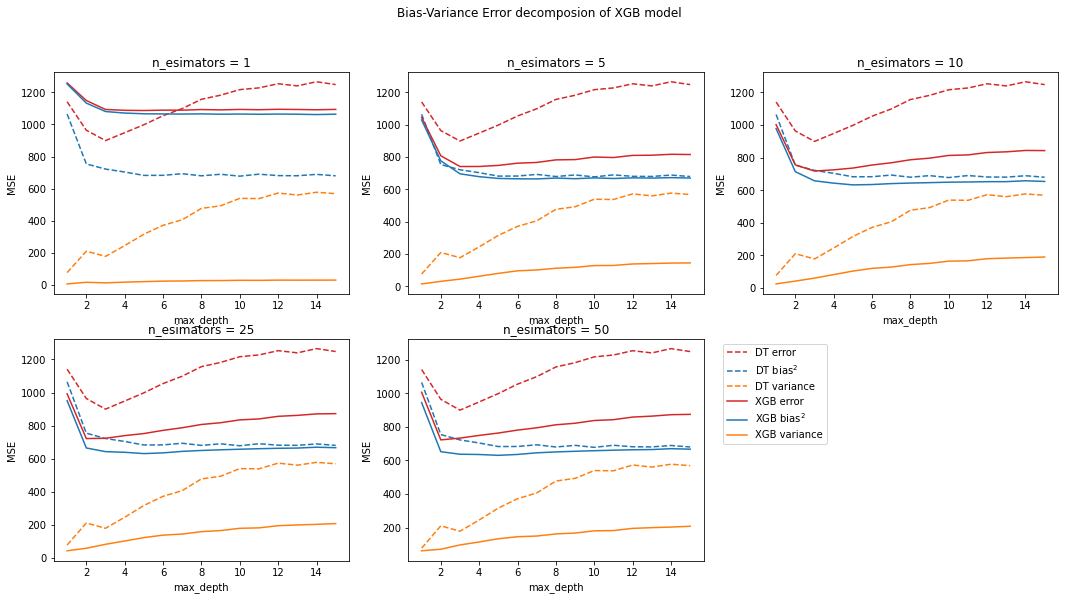

In [35]:
plt.figure(figsize=(18, 9))

for i, n_estimators in enumerate(n_list):
    plt.subplot(2, 3, i + 1)

    plt.plot(x, error, label='DT error', c='tab:red', ls='--')
    plt.plot(x, bias_sq, label='DT bias$^2$', c='tab:blue', ls='--')
    plt.plot(x, variance, label='DT variance', c='tab:orange', ls='--')
    
    plt.plot(x, graphs_dict[n_estimators]['error'],
             label='XGB error', c='tab:red', ls='-')
    plt.plot(x, graphs_dict[n_estimators]['bias'],
             label='XGB bias$^2$', c='tab:blue', ls='-')
    plt.plot(x, graphs_dict[n_estimators]['variance'],
             label='XGB variance',
             c='tab:orange', ls='-')
    
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.title(f'n_esimators = {n_estimators}')
    
plt.suptitle('Bias-Variance Error decomposion of XGB model')
plt.legend(bbox_to_anchor=(1.05, 1))

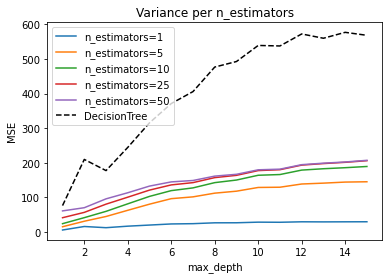

In [36]:
for n_estimators in n_list:
    plt.plot(x, graphs_dict[n_estimators]['variance'],
             label=f'n_estimators={n_estimators}')
    
plt.plot(x, variance, label='DecisionTree', c='black', ls='--')
    
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Variance per n_estimators')
plt.legend()

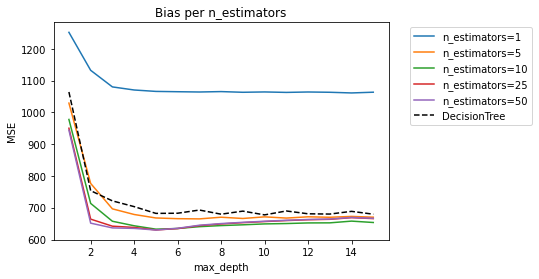

In [37]:
for n_estimators in n_list:
    plt.plot(x, graphs_dict[n_estimators]['bias'],
             label=f'n_estimators={n_estimators}')

plt.plot(x, bias_sq, label='DecisionTree', c='black', ls='--')
    
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Bias per n_estimators')
plt.legend(bbox_to_anchor=(1.05, 1))

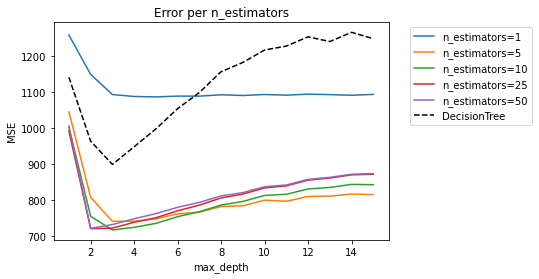

In [38]:
for n_estimators in n_list:
    plt.plot(x, graphs_dict[n_estimators]['error'],
             label=f'n_estimators={n_estimators}')
    
plt.plot(x, error, label='DecisionTree', c='black', ls='--')
    
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Error per n_estimators')
plt.legend(bbox_to_anchor=(1.05, 1))

**4. (3 балла)** Отличаются ли графики в рассмотренных моделях (решающее дерево, градиентный бустинг на решающих деревьях)  между собой? На какую компоненту из разложения ошибки влияет объединение алгоритмов в рассмотренный тип композиции?

Не считая первого графика (`n_estimators=1`), который больше ведет себя как константа, чем дерево решений, можно заметить снижение ошибки. Ошибка уменьшается за счет уменьшения `variance`, `bias` не изменяется. Все это было подтверждено на лекции в теоретической части. 

### 3. (15 баллов) Поисковое ранжирование

![](http://i.imgur.com/2QnD2nF.jpg)

Задачу поискового ранжирования можно описать следующим образом: имеется множество документов $d \in D$ и множество запросов $q \in Q$. Требуется оценить *степень релевантности* документа по отношению к запросу: $(q, d) \mapsto r$, относительно которой будет производиться ранжирование. Для восстановления этой зависимости используются методы машинного обучения. Обычно используется три типа:
 - признаки запроса $q$, например: мешок слов текста запроса, его длина, ...
 - документа $d$, например: значение PageRank, мешок слов, доменное имя, ...
 - пары $(q, d)$, например: число вхождений фразы из запроса $q$ в документе $d$, ...

Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

#### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске используются асессорские оценки. Само оценивание происходит на скрытых от обучения запросах $Queries$. Для этого традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.
Для одного запроса DCG считается следующим образом:
$$ DCG = \sum_{i=1}^P\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$

где $P$ — число документов в поисковой выдаче, $rel_i$ — релевантность (асессорская оценка) документа, находящегося на i-той позиции.

*IDCG* — идеальное (наибольшее из возможных) значение *DCG*, может быть получено путем ранжирования документов по убыванию асессорских оценок.

Итоговая формула для расчета *nDCG*:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$

Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

Загрузите данные конкурса [Интернет-математика 2009](http://imat2009.yandex.ru/datasets). Там же находится описание данных. Разбейте обучающую выборку на обучение и контроль в соотношении 70 / 30. Обратите внимание на формат данных: разбивать необходимо множество запросов, а не строчки датасета.

In [39]:
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    NDCG @k : float
    """
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

In [40]:
data_path = Path('.', 'data')

In [41]:
with data_path.joinpath('imat2009-datasets', 'imat2009_learning.txt').open() as f:
    data = f.readlines()

In [42]:
import re

In [43]:
data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

In [44]:
re.search('# (.+?)\n', data[0]).group(1)

'3382'

In [45]:
queries = {}
for every_line in data:
    query = re.search('# (.+?)\n', every_line).group(1)
    if query not in queries:
        queries[query] = [every_line]
    else:
        queries[query].append(every_line)

In [46]:
from collections import Counter

In [47]:
train, test = train_test_split(list(queries.keys()), test_size=0.3, random_state=1602)

In [48]:
train_str = ''
test_str = ''

In [63]:
q_train = []
q_test = []
for key in queries:
    if key in train:
        for every_string in queries[key]:
            train_str = train_str + every_string
            q_train.append(key)
    else:
        for every_string2 in queries[key]:
            test_str = test_str + every_string2
            q_test.append(key)

In [64]:
len(q_train), len(q_test)

(67721, 29569)

In [52]:
file = open("train.txt", "w") 
file.write(train_str) 
file.close()

file = open("test.txt", "w") 
file.write(test_str) 
file.close() 

In [66]:
from sklearn.datasets import load_svmlight_file

def get_data(file_name):
    data = load_svmlight_file(file_name, query_id=True)
    return data[0], data[1]

X_train, y_train = get_data("train.txt")
X_test, y_test = get_data("test.txt")

In [67]:
X_train.shape, X_test.shape

((67721, 245), (29569, 245))

(array([2.2604e+04, 2.1330e+03, 1.7382e+04, 1.1990e+03, 1.1400e+02,
        2.1286e+04, 3.3700e+02, 1.9080e+03, 1.7000e+01, 7.4100e+02]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

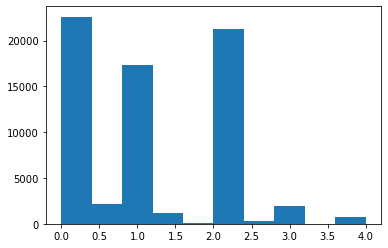

In [68]:
plt.hist(y_train)

Далее рассмотрим несколько подходов предсказания релевантности. Для оценивания качества моделей используйте метрику nDCG на контроле. В случае подбора гиперпараметров используйте кросс-валидацию по 5 блокам.

**4. (3 балла)** [Point-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Pointwise_approach) подход. В этом случае значение функции потерь определяется по одному объекту, например, как в случае регрессии. Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора.

In [69]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [70]:
model = LinearRegression(normalize=True)

In [71]:
%%time
model.fit(X_train, y_train)

CPU times: user 21.2 s, sys: 621 ms, total: 21.8 s
Wall time: 18.4 s


LinearRegression(normalize=True)

In [74]:
max(Counter(q_train).values())

461

In [80]:
np.percentile(list(Counter(q_train).values()), q=[1, 5, 10, 25, 50, 75, 90, 95, 99])

array([ 2.,  3.,  4.,  6.,  9., 13., 16., 19., 32.])

In [83]:
np.mean(list(Counter(q_train).values())), np.median(list(Counter(q_train).values()))

(10.604603820858127, 9.0)

In [85]:
min(Counter(q_train).values())

2

(-20.950000000000003, 40.0)

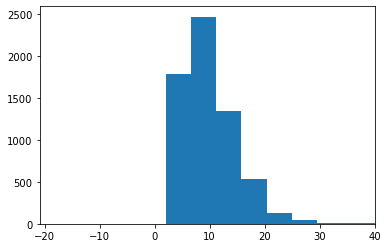

In [82]:
plt.hist(Counter(q_train).values(), bins=100)
plt.xlim(right=40)

Возьмем 10 как длину оцениваемой выдачи для DCG,так как это стандартное значение, а также потому что оно близком к среднему и медиане

In [91]:
def mean_ndcg_score(y_true, y_pred, q_keys):
    df = pd.DataFrame({'y_true': y_true,
                       'y_pred': y_pred,
                       'q_keys': q_keys})
    scores = []
    for key, y_df in df.groupby('q_keys'):
        score = ndcg_score(y_df.y_true, y_df.y_pred, k=10)
        if np.isnan(score):
            print(key, y_df.shape)
        scores.append(ndcg_score(y_df.y_true, y_df.y_pred, k=10))
    
#     return np.mean(scores)
    return scores

In [92]:
y_pred = model.predict(X_train)

In [93]:
mns = mean_ndcg_score(y_train, model.predict(X_train), q_train)

<ipython-input-39-5fedb6c14dca>:50: RuntimeWarning: invalid value encountered in double_scalars
  return actual / best


10010 (2, 3)
10030 (3, 3)
10130 (7, 3)
10142 (11, 3)
10171 (2, 3)
10215 (4, 3)
1026 (4, 3)
10265 (3, 3)
10280 (14, 3)
10317 (4, 3)
10318 (3, 3)
1037 (4, 3)
10452 (11, 3)
10464 (7, 3)
10470 (5, 3)
10478 (6, 3)
10488 (7, 3)
10521 (2, 3)
10567 (3, 3)
10586 (15, 3)
10591 (3, 3)
10718 (6, 3)
1075 (4, 3)
10780 (8, 3)
10843 (7, 3)
10987 (7, 3)
11063 (3, 3)
11100 (3, 3)
11110 (7, 3)
11233 (2, 3)
11245 (7, 3)
11257 (6, 3)
11356 (5, 3)
11363 (2, 3)
11371 (9, 3)
11443 (15, 3)
11473 (7, 3)
11486 (6, 3)
1152 (5, 3)
11524 (2, 3)
11535 (8, 3)
11553 (2, 3)
11591 (23, 3)
1164 (5, 3)
11766 (3, 3)
11779 (11, 3)
11846 (3, 3)
11891 (2, 3)
11905 (6, 3)
11919 (3, 3)
11948 (2, 3)
12094 (8, 3)
12126 (2, 3)
12226 (2, 3)
12228 (5, 3)
12230 (15, 3)
12237 (4, 3)
12261 (10, 3)
12289 (4, 3)
12310 (11, 3)
12366 (4, 3)
1239 (2, 3)
12431 (8, 3)
1247 (10, 3)
12484 (4, 3)
12485 (3, 3)
12507 (7, 3)
12537 (4, 3)
12639 (7, 3)
12701 (8, 3)
12758 (6, 3)
12768 (2, 3)
12793 (3, 3)
12812 (5, 3)
1283 (2, 3)
12837 (3, 3)
12841 (10

9737 (4, 3)
9780 (5, 3)
9827 (8, 3)
9910 (5, 3)


**5. (1 балл)** [Pair-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Pairwise_approach) подход. Здесь функция потерь вычисляется по паре объектов. Постройте ранжирующую модель при помощи [SVMlight](http://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html), реализующий [Ranking SVM](https://en.wikipedia.org/wiki/Ranking_SVM).

In [14]:
# YOUR ANSWER HERE

####  Ранжируем с XGBoost

XGBoost имеет несколько функций потерь для решения задачи ранжирования:
1. **reg:linear** — эта функция потерь нужна для решения задачи регрессии, тем не менее, ее можно использовать в качестве ранжирующей point-wise модели.
2. **rank:pairwise** — в качестве pairwise модели в XGBoost реализован [RankNet](http://research.microsoft.com/en-us/um/people/cburges/papers/ICML_ranking.pdf), в котором минимизируется гладкий функционал качества ранжирования: $$ Obj = \sum_{i \prec j} \mathcal{L}\left(a(x_j) - a(x_i)\right) \rightarrow min $$ $$ \mathcal{L}(M) = log(1 + e^{-M}), $$ где $ a(x) $ - функция ранжирования. Суммирование ведется по всем парам объектов, для которых определено отношение порядка, например, для пар документов, показанных по одному запросу. Таким образом функция потерь штрафует за то, что пара объектов неправильно упорядочена.
3. **rank:map, rank:ndcg** — реализация [LambdaRank](http://research.microsoft.com/en-us/um/people/cburges/papers/lambdarank.pdf) для двух метрик: [MAP](https://www.kaggle.com/wiki/MeanAveragePrecision) и **nDCG**. Известно, что для того, чтобы оптимизировать негладкий функционал, такой как **nDCG**,  нужно домножить градиент функционала $ Obj(a) $ на значение $\Delta NDCG_{ij} $ — изменение значения функционала качества при замене $x_i$ на $ x_j$.  Поскольку для вычисления метрик необходимы все объекты выборки, то эти две ранжирующие функции потерь являются представителями класса [list-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Listwise_approach) моделей.

**6. (3 балла)** Обучите модели **rank:pairwise** и **rank:ndcg**, в качестве метрики оценки качества (*eval_metric*) используя *nDCG*, а в качестве бустера решающее дерево. Рассмотрите различные [параметры](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) бустера: *eta*, *gamma*, *tree_method*. Какие параметры сильнее всего влияют на качество?

In [7]:
# YOUR ANSWER HERE

#### Пользовательская функция потерь

Библиотека XGBoost позволяет использовать пользовательские функции потерь. Для этого необходимо реализовать функцию, принимающую на вход вектор предсказанных значений и обучающую выборку, и возвращающую градиент и гессиан, посчитанный по входным данным.

Важно отметить, что XGBoost использует диагональную аппроксимацию гессиана, таким образом все недиагональные элементы считаются малозначимыми и приравниваются нулю, поэтому и градиент, и гессиан являются векторами длины размера обучающей выборки.

**7. (5 баллов)** Реализуйте экспоненциальную функцию потерь для XGBoost:
$$ Obj = \sum_{i \prec j} \mathcal{L}\left(a(x_j) - a(x_i)\right) \rightarrow min $$ $$ \mathcal{L}(M) = e^{-M} $$

Обучите модель с помощью данной функции потерь, настройте параметры.

In [8]:
# YOUR ANSWER HERE

**Комментарии к реализации**

В случае ранжирования XGBoost'у необходимо знать о разбиении всех объектов на группы. В нашем случае в одну группу будут входить документы, соответствующие одному запросу. Функция, считающая градиент и гессиан по данным, должна знать данное разбиение датасета. Однако питоновский интерфейс класса *DMatrix* (в котором хранится датасет) не дает возможности получить это разбиение. В этом случае нужно реализовать функцию потерь в качестве функтора, конструктор которого принимает разбиение на группы в качестве параметра.


In [10]:
class ExponentialPairwiseLoss(object):
    def __init__(self, groups):
        self.groups = groups
                        
    def __call__(self, preds, dtrain):
        # YOUR ANSWER HERE
        pass

In [9]:
# YOUR ANSWER HERE

**8. (3 балла)** Сравните построенные модели с точки зрения метрики nDCG на контроле и проанализируйте полученные результаты:
  - какая модель работает лучше всего для данной задачи? 
  - в чем достоинства/недостатки каждой? 
  - сравните модели между собой: 
   - получается ли сравнимое качество линейного point-wise подхода с остальными моделями? 
   - согласуются ли результаты для *Ranking SVM* и *rank:pairwise*?
   - заметна ли разница в качестве при использовании бустинга с разными функциями потерь?

In [11]:
# YOUR ANSWER HERE

### 4 (15 баллов). catboost vs lightgbm


**1. (15 баллов)** Рассмотрите одиночную модель, основанную на библиотеке `catboost`, команды, занявшей второе место в конкурсе [Kaggle: IEEE Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection). Краткое описание финального решения находится по [ссылке](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111554). Код для обучения модели находится по [ссылке](https://gitlab.com/saygogoplz/ieee-fraud-detection/-/blob/master/submission_777_tony_cpmp_shifts_giba_fs-1.py). Разберите концепцию пайплайна одиночной модели на catboost, и ответьте на вопрос - почему отбор признаков при помощи случайного леса хорошо работает для в пайплайне? Перепешите пайплайн на библиотеке lightgbm, принципиально ничего не меняя и не пребегая к генерациию заведомо новых признаков, так чтобы побить пайплайн на библиотеке `catboost` на приватном и публичном лидербордах (be like a Giba :). Результатом решения должны быть - код пайплайна на `lightgbm` (с краткими комментариями основных изменений), а также скриншот результатов двух пайплайнов из `my submissions` после сделанных `late submission`.

In [15]:
# YOUR ANSWER HERE